In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)

2.3.1


In [3]:
mpl.rcParams['figure.figsize'] = (10,7.5)
mpl.rcParams['axes.grid'] = False

In [4]:
tf.random.set_seed(51)
np.random.seed(51)

## Appliance energy dataset 

In [5]:
df = pd.read_csv('energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
df = df[::6]
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,47.233763,47.233763
12,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,34.351142,34.351142
18,2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,19.001759,19.001759
24,2016-01-11 21:00:00,110,30,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,13.361033,13.361033


In [7]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

In [8]:
df.shape

(3290, 28)

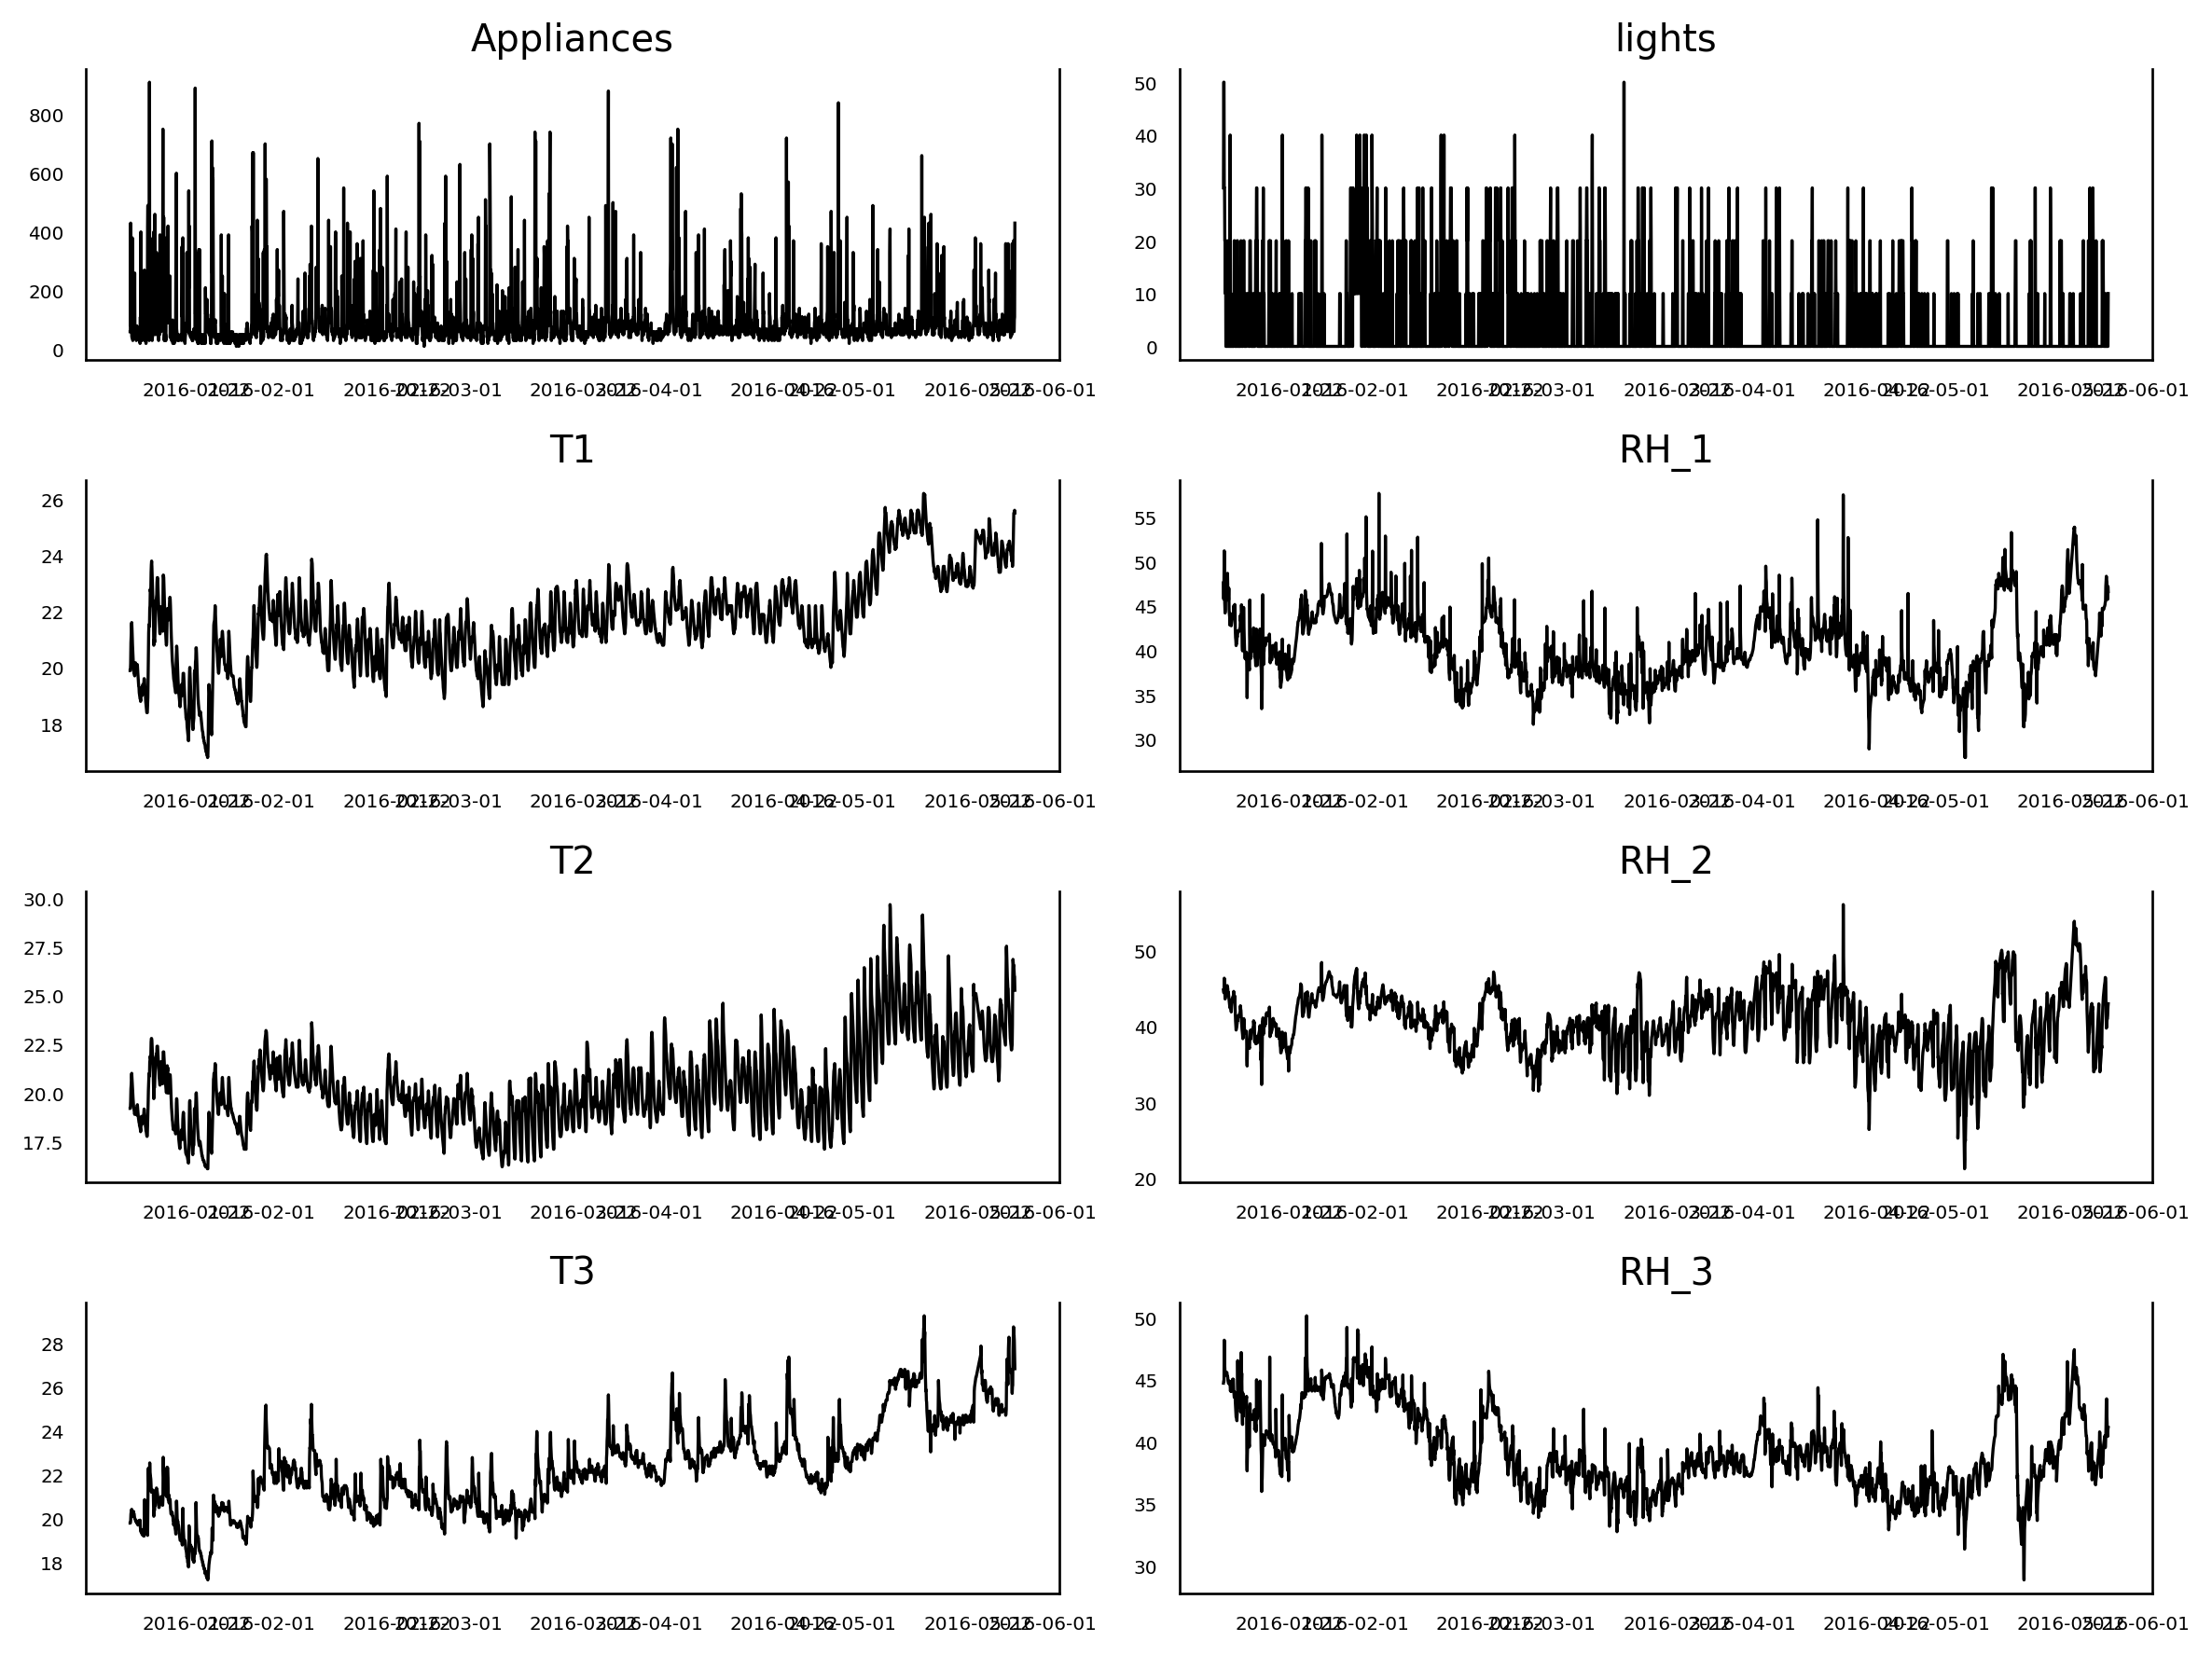

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=240)

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color='black', linewidth=1)
    
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

## EDA (Exploratory Data Analysis) 

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333


In [11]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)

In [12]:
df.shape

(3290, 25)

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333
T5,3290.0,19.593729,1.846567,15.335000,18.290000,19.390000,20.613492,25.466667


## Feature Engineering
### Time

In [14]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

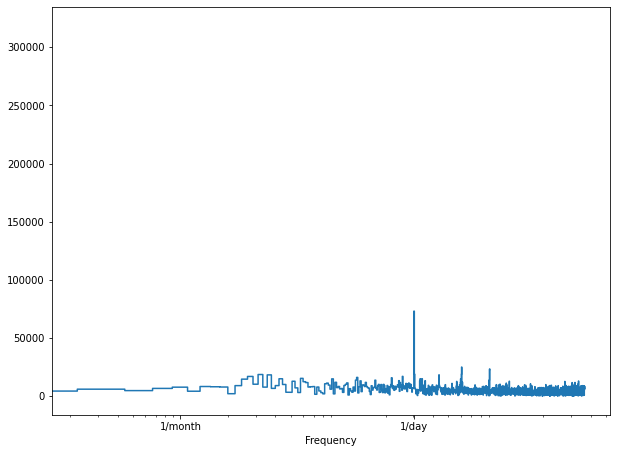

In [15]:
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h/hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/month', '1/day'])
plt.xlabel('Frequency')
plt.show()

In [16]:
day = 24 * 60 * 60

df['Day sin'] = (np.sin(timestamp_s * (2 * np.pi / day))).values
df['Day cos'] = (np.cos(timestamp_s * (2 * np.pi / day))).values

In [17]:
df.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Day sin,Day cos
0,60,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,-5.000000e-01,0.866025
6,60,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,-2.588190e-01,0.965926
12,430,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,-1.233163e-11,1.000000
18,80,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,2.588190e-01,0.965926
24,110,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,5.000000e-01,0.866025


## Split data 

In [18]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

There are 27 features


## Normalize data 

In [19]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

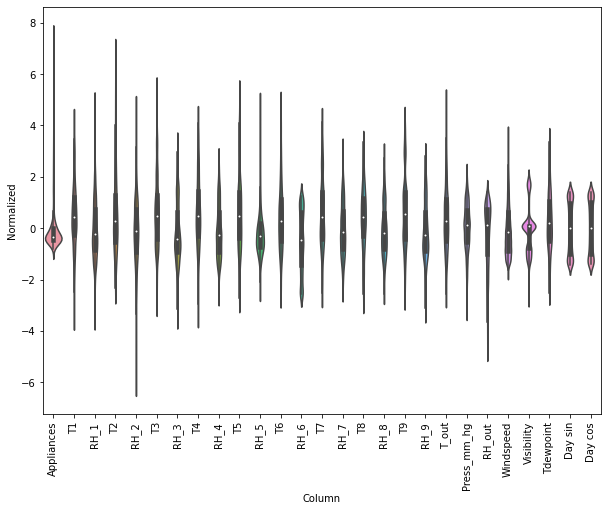

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing 

In [21]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

## Single Step Models 

In [22]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Appliances'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

### Baseline 

In [23]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [24]:
baseline = Baseline(label_index=column_indices['Appliances'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 2ms/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [25]:
wide_window = WindowGenerator(input_width=24,
                             label_width=24,
                             shift=1,
                             label_columns=['Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

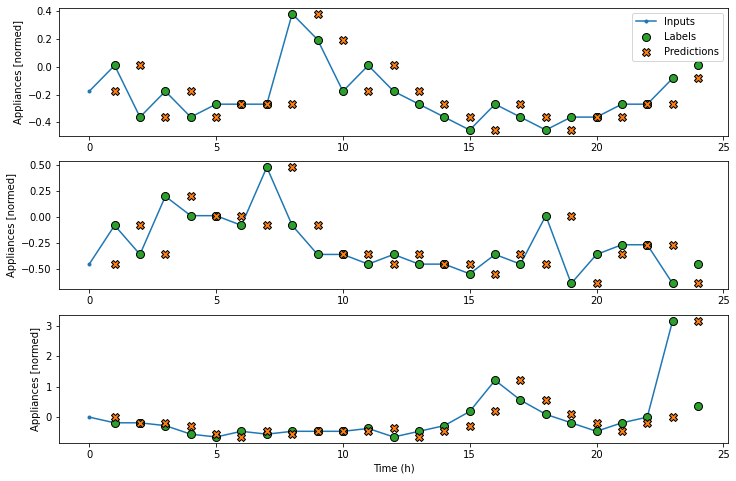

In [26]:
wide_window.plot(baseline)

### Linear model 

In [27]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [28]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=patience,
                                                     mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [29]:
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 2ms/step - loss: 1.4039 - mean_absolute_error: 0.8447 - val_loss: 0.9472 - val_mean_absolute_error: 0.6777
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 1.0720 - mean_absolute_error: 0.6768 - val_loss: 0.7654 - val_mean_absolute_error: 0.5689
Epoch 3/50
72/72 [==============================] - 0s 1ms/step - loss: 0.9784 - mean_absolute_error: 0.6141 - val_loss: 0.6865 - val_mean_absolute_error: 0.5070
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 0.9328 - mean_absolute_error: 0.5832 - val_loss: 0.6520 - val_mean_absolute_error: 0.4764
Epoch 5/50
72/72 [==============================] - 0s 1ms/step - loss: 0.9066 - mean_absolute_error: 0.5656 - val_loss: 0.6293 - val_mean_absolute_error: 0.4476
Epoch 6/50
72/72 [==============================] - 0s 1ms/step - loss: 0.8897 - mean_absolute_error: 0.5546 - val_loss: 0.6150 - val_mean_absolute_error: 0.4388
Epoch 7/50
72/72 [==========

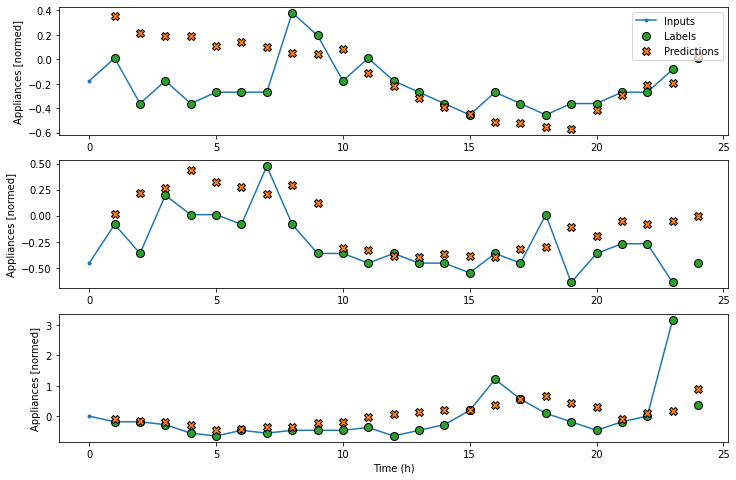

In [30]:
wide_window.plot(linear)

### Dense 

In [31]:
from tensorflow.keras.models import Sequential

In [32]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 3ms/step - loss: 0.9191 - mean_absolute_error: 0.5509 - val_loss: 0.5803 - val_mean_absolute_error: 0.4979
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8154 - mean_absolute_error: 0.5101 - val_loss: 0.5440 - val_mean_absolute_error: 0.3938
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7797 - mean_absolute_error: 0.5019 - val_loss: 0.5594 - val_mean_absolute_error: 0.4103
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7604 - mean_absolute_error: 0.4986 - val_loss: 0.5775 - val_mean_absolute_error: 0.4258
Epoch 5/50
21/21 [==============================] - 0s 828us/step - loss: 0.5666 - mean_absolute_error: 0.4273


### CNN 

In [33]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Appliances']
)

In [34]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Appliances'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Appliances']

In [35]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH,),
                          activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 3ms/step - loss: 0.9198 - mean_absolute_error: 0.5611 - val_loss: 0.5548 - val_mean_absolute_error: 0.4114
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8151 - mean_absolute_error: 0.5224 - val_loss: 0.5481 - val_mean_absolute_error: 0.4004
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7712 - mean_absolute_error: 0.5139 - val_loss: 0.5998 - val_mean_absolute_error: 0.4099
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7462 - mean_absolute_error: 0.4891 - val_loss: 0.6110 - val_mean_absolute_error: 0.4166
Epoch 5/50
21/21 [==============================] - 0s 812us/step - loss: 0.5804 - mean_absolute_error: 0.3944


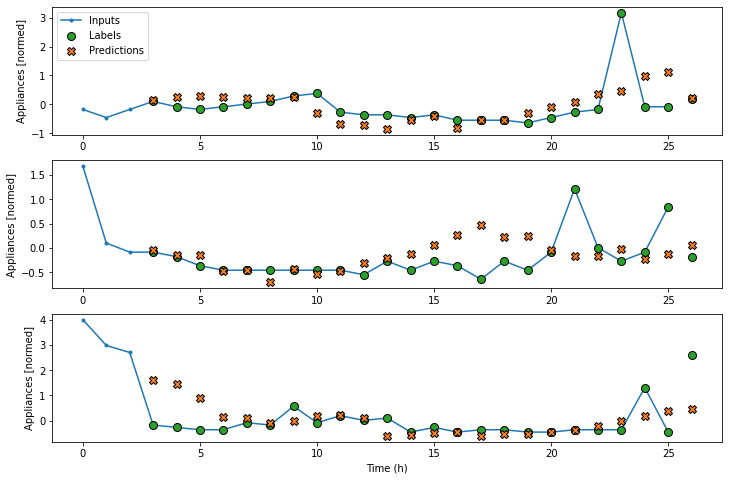

In [36]:
wide_conv_window.plot(cnn_model)

### LSTM 

In [37]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8874 - mean_absolute_error: 0.5327 - val_loss: 0.5553 - val_mean_absolute_error: 0.3991
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 0.7602 - mean_absolute_error: 0.4873 - val_loss: 0.5761 - val_mean_absolute_error: 0.4107
Epoch 3/50
72/72 [==============================] - 0s 5ms/step - loss: 0.7018 - mean_absolute_error: 0.4671 - val_loss: 0.5943 - val_mean_absolute_error: 0.4331
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6170 - mean_absolute_error: 0.4507


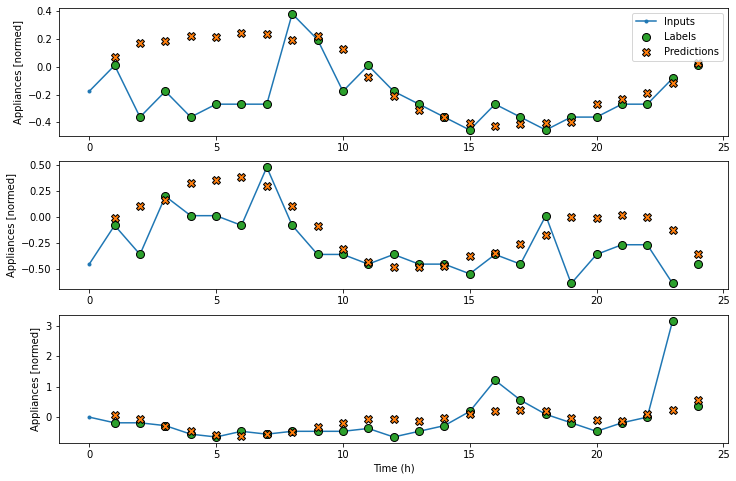

In [38]:
wide_window.plot(lstm_model)

### CNN + LSTM 

In [39]:
cnn_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH,),
                          activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.9727 - mean_absolute_error: 0.5608 - val_loss: 0.5646 - val_mean_absolute_error: 0.4113
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8381 - mean_absolute_error: 0.5003 - val_loss: 0.5756 - val_mean_absolute_error: 0.3614
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7862 - mean_absolute_error: 0.4863 - val_loss: 0.5497 - val_mean_absolute_error: 0.3535
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7576 - mean_absolute_error: 0.4731 - val_loss: 0.5535 - val_mean_absolute_error: 0.3342
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 0.7332 - mean_absolute_error: 0.4645 - val_loss: 0.5804 - val_mean_absolute_error: 0.3420
Epoch 6/50
21/21 [==============================] - 0s 1ms/step - loss: 0.5858 - mean_absolute_error: 0.3400


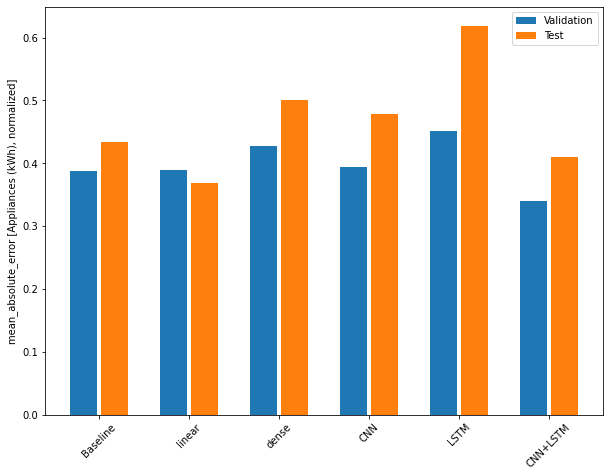

In [40]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Appliances (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [41]:
for name, value in performance.items():
    print(f'{name}: {value[1]:0.4f}')

Baseline: 0.4342
linear: 0.3684
dense: 0.5011
CNN: 0.4779
LSTM: 0.6179
CNN+LSTM: 0.4101


## Multi Output Models 

In [42]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1
)

wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1
)

CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 27)
Labels shape (batch, time, features): (32, 24, 27)


### Baseline 

In [43]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['baseline'] = baseline.evaluate(wide_window.val)
performance['baseline'] = baseline.evaluate(wide_window.test, verbose=0)

20/20 [==============================] - 0s 750us/step - loss: 0.1296 - mean_absolute_error: 0.1775


### Dense 

In [44]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 3ms/step - loss: 0.5931 - mean_absolute_error: 0.5869 - val_loss: 0.5200 - val_mean_absolute_error: 0.5394
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.2722 - mean_absolute_error: 0.3732 - val_loss: 0.3523 - val_mean_absolute_error: 0.4379
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.2048 - mean_absolute_error: 0.3119 - val_loss: 0.2704 - val_mean_absolute_error: 0.3764
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1749 - mean_absolute_error: 0.2799 - val_loss: 0.2376 - val_mean_absolute_error: 0.3517
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1588 - mean_absolute_error: 0.2607 - val_loss: 0.2243 - val_mean_absolute_error: 0.3397
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1487 - mean_absolute_error: 0.2469 - val_loss: 0.2049 - val_mean_absolute_error: 0.3194
Epoch 7/50
72/72 [==========

### LSTM 

In [45]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.7067 - mean_absolute_error: 0.6538 - val_loss: 1.2631 - val_mean_absolute_error: 0.8200
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.3783 - mean_absolute_error: 0.4570 - val_loss: 0.8789 - val_mean_absolute_error: 0.6713
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2806 - mean_absolute_error: 0.3795 - val_loss: 0.7429 - val_mean_absolute_error: 0.6085
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2335 - mean_absolute_error: 0.3361 - val_loss: 0.6476 - val_mean_absolute_error: 0.5637
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2040 - mean_absolute_error: 0.3063 - val_loss: 0.5745 - val_mean_absolute_error: 0.5278
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1827 - mean_absolute_error: 0.2836 - val_loss: 0.5143 - val_mean_absolute_error: 0.4970
Epoch 7/50
72/72 [==========

### CNN + LSTM 

In [46]:
cnn_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH,),
                          activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8650 - mean_absolute_error: 0.7406 - val_loss: 1.9501 - val_mean_absolute_error: 1.1139
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8245 - mean_absolute_error: 0.7199 - val_loss: 1.9335 - val_mean_absolute_error: 1.1116
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8227 - mean_absolute_error: 0.7190 - val_loss: 1.9159 - val_mean_absolute_error: 1.1073
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8220 - mean_absolute_error: 0.7187 - val_loss: 1.9113 - val_mean_absolute_error: 1.1064
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8215 - mean_absolute_error: 0.7186 - val_loss: 1.9121 - val_mean_absolute_error: 1.1059
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8211 - mean_absolute_error: 0.7183 - val_loss: 1.9048 - val_mean_absolute_error: 1.1046
Epoch 7/50
72/72 [==========

### ResNet 

In [47]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        
        return inputs + delta

In [48]:
res_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features,
            kernel_initializer=tf.initializers.zeros    # Initialize predictions to 0
        )
    ])
)

history = compile_and_fit(res_lstm, wide_window)

val_performance['res_lstm'] = res_lstm.evaluate(wide_window.val)
performance['res_lstm'] = res_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1473 - mean_absolute_error: 0.1690 - val_loss: 0.1143 - val_mean_absolute_error: 0.1619
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1293 - mean_absolute_error: 0.1579 - val_loss: 0.1055 - val_mean_absolute_error: 0.1641
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1111 - mean_absolute_error: 0.1546 - val_loss: 0.1031 - val_mean_absolute_error: 0.1656
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1019 - mean_absolute_error: 0.1525 - val_loss: 0.1045 - val_mean_absolute_error: 0.1674
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0972 - mean_absolute_error: 0.1506 - val_loss: 0.1056 - val_mean_absolute_error: 0.1689
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1069 - mean_absolute_error: 0.1711


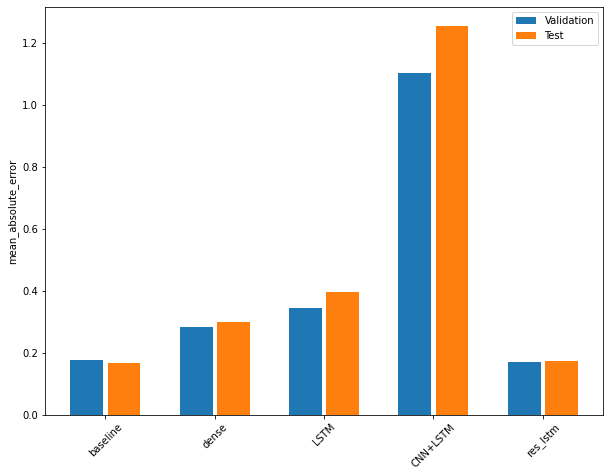

In [49]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [50]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

baseline    : 0.1658
dense       : 0.2988
LSTM        : 0.3964
CNN+LSTM    : 1.2541
res_lstm    : 0.1736


## Multi Step Models 

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

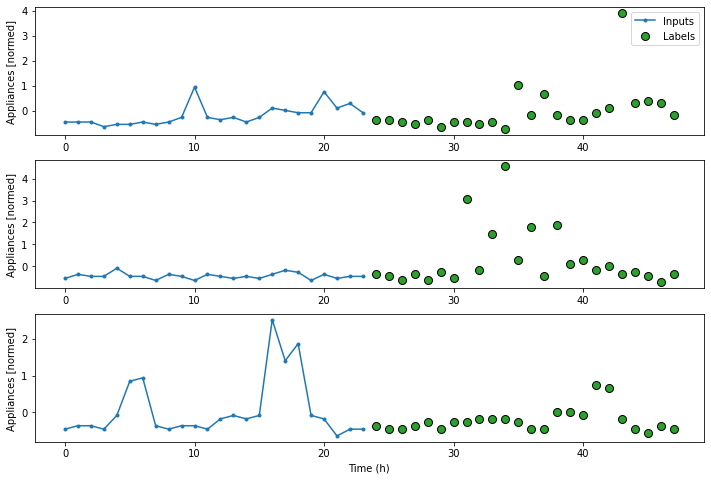

In [51]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=24,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline 

In [52]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:,-1:,:], [1, OUT_STEPS, 1])

In [53]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                     metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 1ms/step - loss: 0.9511 - mean_absolute_error: 0.6514


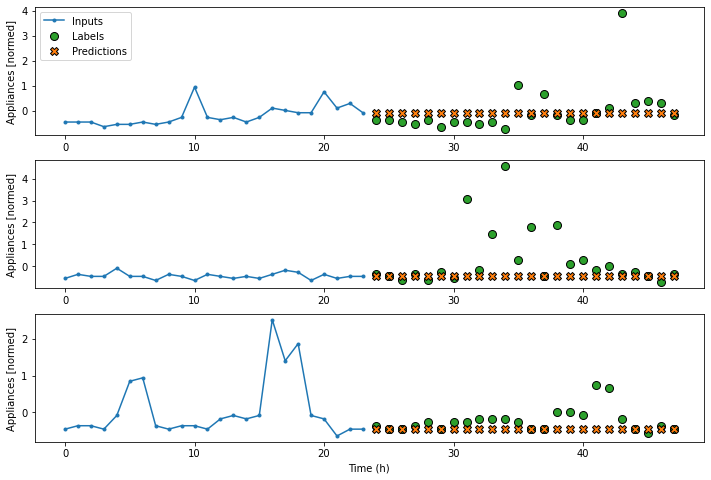

In [54]:
multi_window.plot(last_baseline)

In [55]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [56]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                       metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 750us/step - loss: 0.5227 - mean_absolute_error: 0.4846


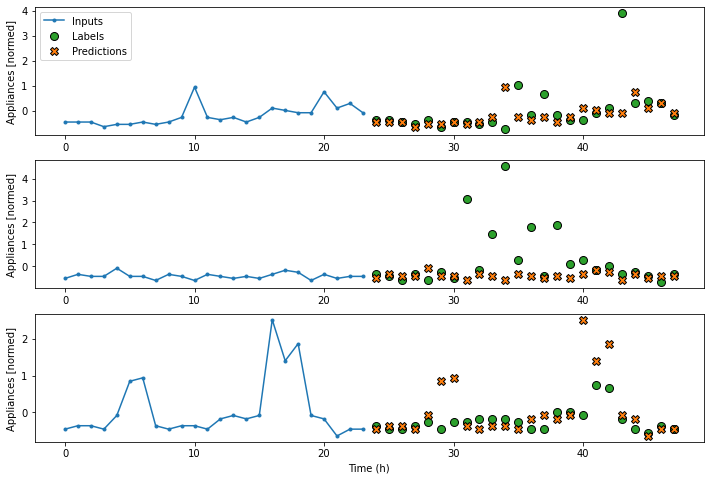

In [57]:
multi_window.plot(repeat_baseline)

### Linear - Single shot 

In [58]:
multi_linear_model = tf.keras.Sequential([
    # Take last time step
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,      # Shape [batch, 1, out_steps*features]
                         kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 2ms/step - loss: 0.7003 - mean_absolute_error: 0.6586 - val_loss: 0.9471 - val_mean_absolute_error: 0.7272
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.4668 - mean_absolute_error: 0.5166 - val_loss: 0.7209 - val_mean_absolute_error: 0.6087
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.4096 - mean_absolute_error: 0.4742 - val_loss: 0.6650 - val_mean_absolute_error: 0.5768
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3812 - mean_absolute_error: 0.4525 - val_loss: 0.6345 - val_mean_absolute_error: 0.5596
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3636 - mean_absolute_error: 0.4384 - val_loss: 0.6150 - val_mean_absolute_error: 0.5489
Epoch 6/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3512 - mean_absolute_error: 0.4280 - val_loss: 0.5979 - val_mean_absolute_error: 0.5385
Epoch 7/50
71/71 [==========

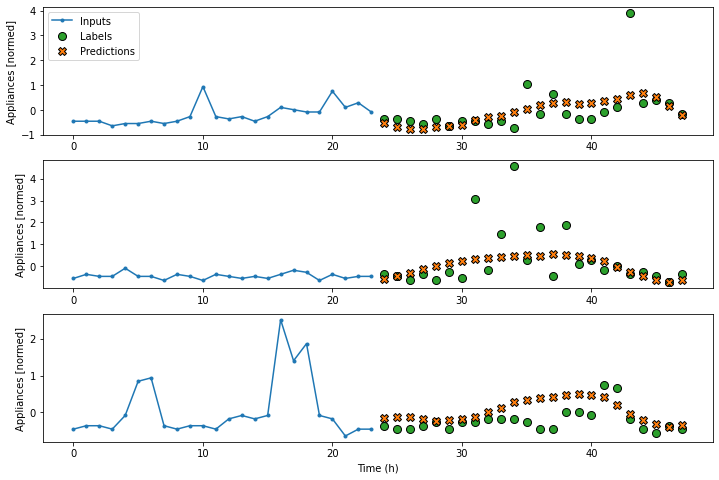

In [59]:
multi_window.plot(multi_linear_model)

### Dense - Single shot 

In [60]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                         kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 4ms/step - loss: 0.4644 - mean_absolute_error: 0.5018 - val_loss: 0.6441 - val_mean_absolute_error: 0.5545
Epoch 2/50
71/71 [==============================] - 0s 3ms/step - loss: 0.3004 - mean_absolute_error: 0.3776 - val_loss: 0.6186 - val_mean_absolute_error: 0.5312
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2781 - mean_absolute_error: 0.3558 - val_loss: 0.5843 - val_mean_absolute_error: 0.5155
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2653 - mean_absolute_error: 0.3443 - val_loss: 0.5890 - val_mean_absolute_error: 0.5166
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2552 - mean_absolute_error: 0.3352 - val_loss: 0.5926 - val_mean_absolute_error: 0.5145
Epoch 6/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5886 - mean_absolute_error: 0.5167


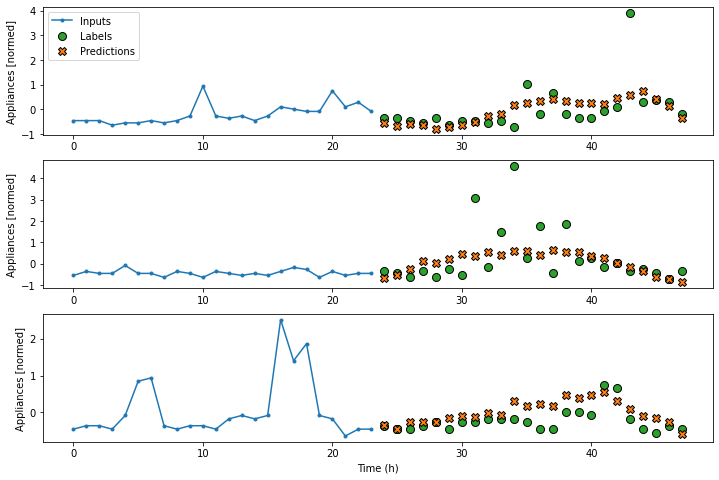

In [61]:
multi_window.plot(multi_dense_model)

### CNN - Single shot 

In [62]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),         # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Conv1D(256, activation='relu', 
                           kernel_size=(CONV_WIDTH)),                # Shape [batch, 1, conv_units]
    tf.keras.layers.Dense(OUT_STEPS*num_features, 
                          kernel_initializer=tf.initializers.zeros), #Shape [batch, 1, out_step*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])               #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 3ms/step - loss: 0.4878 - mean_absolute_error: 0.5180 - val_loss: 0.6489 - val_mean_absolute_error: 0.5705
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3091 - mean_absolute_error: 0.3864 - val_loss: 0.6025 - val_mean_absolute_error: 0.5398
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2834 - mean_absolute_error: 0.3629 - val_loss: 0.6080 - val_mean_absolute_error: 0.5417
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2679 - mean_absolute_error: 0.3495 - val_loss: 0.5987 - val_mean_absolute_error: 0.5356
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2564 - mean_absolute_error: 0.3396 - val_loss: 0.6037 - val_mean_absolute_error: 0.5331
Epoch 6/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2468 - mean_absolute_error: 0.3312 - val_loss: 0.6085 - val_mean_absolute_error: 0.5342
Epoch 7/50
20/20 [==========

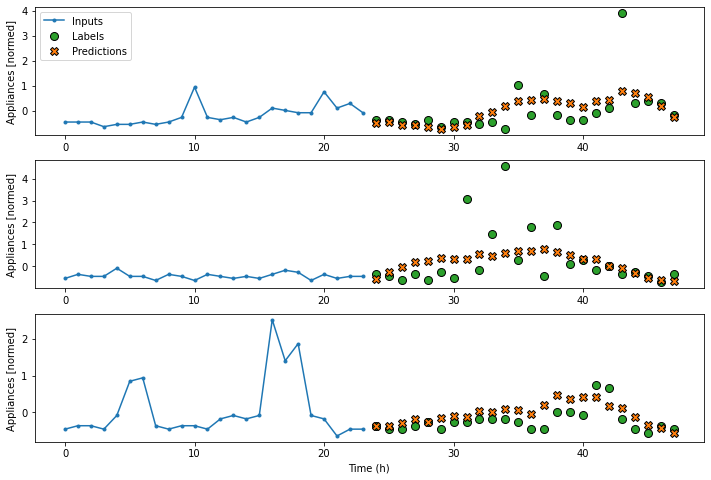

In [63]:
multi_window.plot(multi_conv_model)

### LSTM - Single shot 

In [64]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                         kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 9ms/step - loss: 0.7729 - mean_absolute_error: 0.6932 - val_loss: 1.6047 - val_mean_absolute_error: 0.9586
Epoch 2/50
71/71 [==============================] - 0s 6ms/step - loss: 0.5366 - mean_absolute_error: 0.5581 - val_loss: 1.3588 - val_mean_absolute_error: 0.8711
Epoch 3/50
71/71 [==============================] - 0s 6ms/step - loss: 0.4572 - mean_absolute_error: 0.5077 - val_loss: 1.2171 - val_mean_absolute_error: 0.8177
Epoch 4/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3722 - mean_absolute_error: 0.4462 - val_loss: 1.0545 - val_mean_absolute_error: 0.7545
Epoch 5/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3279 - mean_absolute_error: 0.4091 - val_loss: 1.0236 - val_mean_absolute_error: 0.7436
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3078 - mean_absolute_error: 0.3923 - val_loss: 1.0175 - val_mean_absolute_error: 0.7405
Epoch 7/50
71/71 [==========

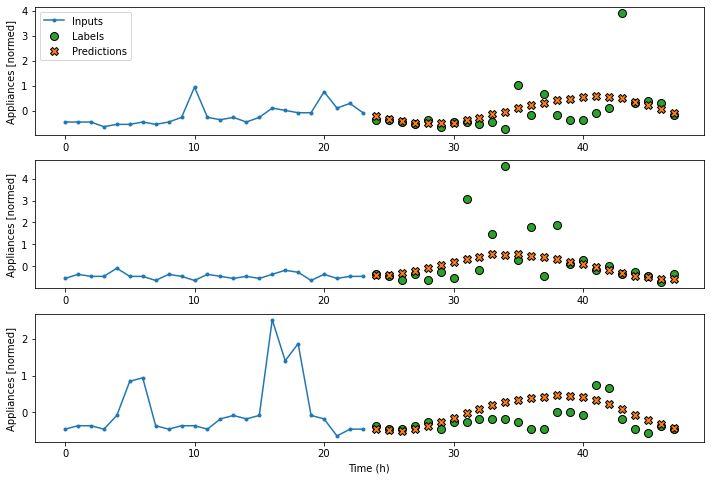

In [65]:
multi_window.plot(multi_lstm_model)

### CNN + LSTM - Single shot 

In [66]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),         # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Conv1D(256, activation='relu', 
                           kernel_size=(CONV_WIDTH)),                # Shape [batch, 1, conv_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, 
                          kernel_initializer=tf.initializers.zeros), #Shape [batch, 1, out_step*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])               #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['CNN+LSTM'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN+LSTM'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 9ms/step - loss: 0.8600 - mean_absolute_error: 0.7366 - val_loss: 1.6517 - val_mean_absolute_error: 0.9612
Epoch 2/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5794 - mean_absolute_error: 0.5801 - val_loss: 1.3316 - val_mean_absolute_error: 0.8599
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.5166 - mean_absolute_error: 0.5415 - val_loss: 1.2365 - val_mean_absolute_error: 0.8411
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.4694 - mean_absolute_error: 0.5136 - val_loss: 1.1563 - val_mean_absolute_error: 0.8075
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.4147 - mean_absolute_error: 0.4770 - val_loss: 1.0794 - val_mean_absolute_error: 0.7792
Epoch 6/50
71/71 [==============================] - 0s 3ms/step - loss: 0.3638 - mean_absolute_error: 0.4393 - val_loss: 1.0279 - val_mean_absolute_error: 0.7419
Epoch 7/50
71/71 [==========

### LSTM - Autoregressive 

In [67]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x,
                                     states=state,
                                     training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

Epoch 1/50
71/71 [==============================] - 1s 14ms/step - loss: 0.7729 - mean_absolute_error: 0.6863 - val_loss: 1.4946 - val_mean_absolute_error: 0.9055
Epoch 2/50
71/71 [==============================] - 1s 8ms/step - loss: 0.5435 - mean_absolute_error: 0.5602 - val_loss: 1.3911 - val_mean_absolute_error: 0.8783
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.4948 - mean_absolute_error: 0.5300 - val_loss: 1.3239 - val_mean_absolute_error: 0.8512
Epoch 4/50
71/71 [==============================] - 1s 8ms/step - loss: 0.4347 - mean_absolute_error: 0.4916 - val_loss: 1.1986 - val_mean_absolute_error: 0.8118
Epoch 5/50
71/71 [==============================] - 1s 8ms/step - loss: 0.3762 - mean_absolute_error: 0.4496 - val_loss: 1.1175 - val_mean_absolute_error: 0.7834
Epoch 6/50
71/71 [==============================] - 1s 8ms/step - loss: 0.3440 - mean_absolute_error: 0.4244 - val_loss: 1.0956 - val_mean_absolute_error: 0.7786
Epoch 7/50
71/71 [=========

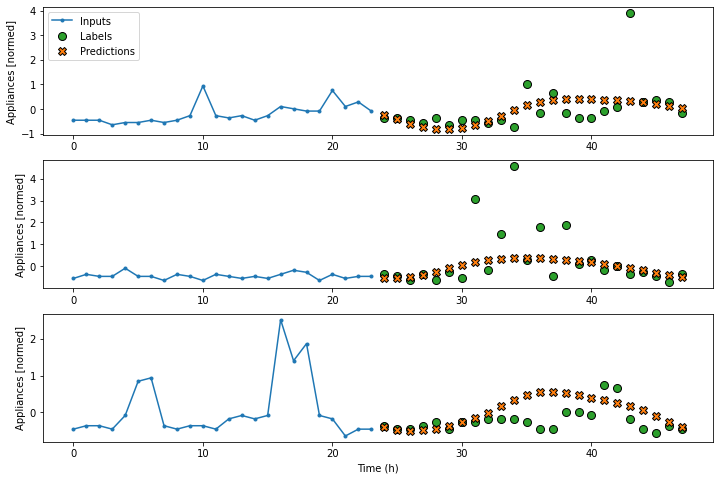

In [68]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

multi_window.plot(feedback_model)

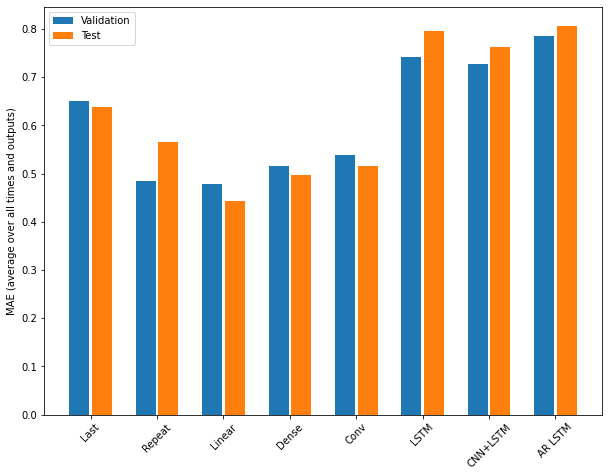

In [69]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend(loc='best')
plt.show()

In [70]:
for name, value in multi_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Last        : 0.6389
Repeat      : 0.5648
Linear      : 0.4437
Dense       : 0.4973
Conv        : 0.5165
LSTM        : 0.7954
CNN+LSTM    : 0.7618
AR LSTM     : 0.8052
